In [ ]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time

In [ ]:
os.environ['TOKEN'] = 'AAAAAAAAAAAAAAAAAAAAACzPZgEAAAAAUbTj7vOIhhmxJddqJnYf18MWnrA%3DBoZHZgD03Q36JPKiCmPOwF4sZPPEqo7LurTKH0LiCPT3rTpnhZ'

In [ ]:
'''
Utility function

auth() -> retrieve the twitter bearer token from env
'''
def auth():
    return os.getenv('TOKEN')

In [ ]:
'''
Create twitter headers

define a function that will take our bearer token, pass it for authorization and return headers we will use to access the API.

'''

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [ ]:
def create_url(keyword, start_date, end_date, max_results = 500):
    
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id',
                    'user.fields': 'id,name,username',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

In [ ]:
#Connecting to twitter endpoint

#RESPONSE CODE 200: SUCCESS

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [ ]:
'''
append_to_csv() function, 
will input the response and desired filename into, and the function will append all the data we collected to the CSV file.
'''

def append_to_csv(json_response, fileName):
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']


        # 4. Tweet ID
        tweet_id = tweet['id']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        res = [author_id, tweet_id, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [ ]:
#Inputs for tweets

bearer_token = auth()
headers = create_headers(bearer_token)
keyword_list = "(acab OR bluelivesmatter) lang:en -is:retweet -is:reply"
                
start_list =    ['2020-05-01T00:00:00.000Z',
                 '2020-05-01T00:00:00.000Z',
                 '2020-06-01T00:00:00.000Z',
                 '2020-06-01T00:00:00.000Z',
                 '2022-05-01T00:00:00.000Z',
                 '2022-05-01T00:00:00.000Z'
                 ]

end_list =      ['2020-05-30T00:00:00.000Z',
                 '2020-05-30T00:00:00.000Z',
                 '2020-06-30T00:00:00.000Z',
                 '2020-06-30T00:00:00.000Z',
                 '2022-05-10T00:00:00.000Z',
                 '2022-05-10T00:00:00.000Z']
max_results = 500

#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open("police_data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

csvWriter.writerow(['author id', 'id','tweet'])
csvFile.close()

for i in range(0,len(start_list)):

    # Inputs
    count = 0 # Counting tweets per time period
    max_count = 100 # Max tweets per time period
    flag = True
    next_token = None
    
    # Check if flag is true
    while flag:
        # Check if max_count reached
        if count >= max_count:
            break
        print("-------------------")
        print("Token: ", next_token)
        url = create_url(keyword_list, start_list[i],end_list[i], max_results)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
        result_count = json_response['meta']['result_count']

        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
            print("Next Token: ", next_token)
            if result_count is not None and result_count > 0 and next_token is not None:
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, "police_data.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)                
        # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, "police_data.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)
            
            #Since this is the final request, turn flag to false to move to the next time period.
            flag = False
            next_token = None
        time.sleep(5)
print("Total number of results: ", total_tweets)

-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7dfft8en6m1ljqztg11bq5qlx2f1
Start Date:  2020-05-01T00:00:00.000Z
# of Tweets added from this response:  472
Total # of Tweets added:  472
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7dfft8en6m1ksdwfdvv944310kfx
Start Date:  2020-05-01T00:00:00.000Z
# of Tweets added from this response:  473
Total # of Tweets added:  945
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7gfmx2nynr4eyj53dl7x030k7n25
Start Date:  2020-06-01T00:00:00.000Z
# of Tweets added from this response:  470
Total # of Tweets added:  1415
-------------------
-------------------
Token:  None
Endpoint Response Code: 200
Next Token:  b26v89c19zqg8o3fo7gfmx2nynr4eyj53dl7x030k7n25
Start Date:  2020-06-01T00:00:00.000Z
# of Tweets added from this response:  470
Total # of Tweets added:  1885
--------------

In [ ]:
#MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("police_data.csv")
df.drop(columns=["author id", "id"], axis=1, inplace=True)
df

,tweet
0,this looked like a skit in the beginning. Are ...
1,"please block me if:\n- ""not all cops""\n- you t..."
2,I'm sorry I've been so silent on twitter about...
3,As an empath and someone who’s fucking sensiti...
4,not wasting my time arguing acab.
...,...
2870,DHS Cop Car Smashed in Protest against Supreme...
2871,its acab but y'all i saw the FINEST mfn cop ev...
2872,acab includes the beeping noise when i don’t p...
2873,Indiana Files Lawsuit Against Black Lives Matt...


In [ ]:
import re
import string

df['hashtag'] = df['tweet'].apply(lambda x: re.findall(r"#(\w+)", x))

In [ ]:
df['tweet'][2]

"I'm sorry I've been so silent on twitter about #ACAB and about all the death that is happening in my country right now. I just want to say that I support all the people that are protesting this injustice. I wish I could stand beside you."

In [ ]:
urlPattern = r"((https://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

def preprocess_first(tweet):
  tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
  tweet = re.sub(userPattern,'', tweet) 
  return tweet

df['preprocessed_tweets'] = df['tweet'].apply(lambda x: preprocess_first(x))

In [ ]:
!pip install wordsegment
from wordsegment import load, segment

     |████████████████████████████████| 4.8 MB 5.2 MB/s 


In [ ]:
load()
def hash_fix(h):
    h1 = re.sub(r'[0-9]+', '', h)
    h2 = re.sub(r'#', '', h1)
    h3 = segment(str(h2))
    h4 = ' '.join(map(str, h3)) 
    return h4

df['preprocessed_tweets'] = df['preprocessed_tweets'].apply(lambda x: hash_fix(x))
df

,tweet,hashtag,preprocessed_tweets
0,this looked like a skit in the beginning. Are ...,[],this looked like ask it in the beginning are y...
1,"please block me if:\n- ""not all cops""\n- you t...",[],please block me if not all cops you think blm ...
2,I'm sorry I've been so silent on twitter about...,[ACAB],im sorry ive been so silent on twitter about a...
3,As an empath and someone who’s fucking sensiti...,"[JusticeForGeorgeFlyod, ACAB]",as an empath and someone who s fucking sensiti...
4,not wasting my time arguing acab.,[],not wasting my time arguing a cab
...,...,...,...
2870,DHS Cop Car Smashed in Protest against Supreme...,"[LosAngeles, ACAB, FTP]",dhs cop car smashed in protest against supreme...
2871,its acab but y'all i saw the FINEST mfn cop ev...,[],its a cab but yall i saw the finest mfn cop ev...
2872,acab includes the beeping noise when i don’t p...,[],a cab includes the beeping noise when i dont p...
2873,Indiana Files Lawsuit Against Black Lives Matt...,"[BlueLivesMatter, BackTheBlue, lawenforcement,...",indiana files lawsuit against black lives matt...


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

urlPattern = r"((https://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

nltk.download('punkt')
nltk.download('wordnet')

def preprocess_two(tweet):
  # Lower Casing
    tweet = tweet.lower()
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #reducing a word to its word stem 
    #Removing Stop Words
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

df['str_preprocessed_tweets_final'] = df['preprocessed_tweets'].apply(lambda x: preprocess_two(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df

,tweet,hashtag,preprocessed_tweets,str_preprocessed_tweets_final
0,this looked like a skit in the beginning. Are ...,[],this looked like ask it in the beginning are y...,this looked like ask it in the beginning are y...
1,"please block me if:\n- ""not all cops""\n- you t...",[],please block me if not all cops you think blm ...,please block me if not all cop you think blm i...
2,I'm sorry I've been so silent on twitter about...,[ACAB],im sorry ive been so silent on twitter about a...,im sorry ive been so silent on twitter about c...
3,As an empath and someone who’s fucking sensiti...,"[JusticeForGeorgeFlyod, ACAB]",as an empath and someone who s fucking sensiti...,a an empath and someone who fucking sensitive ...
4,not wasting my time arguing acab.,[],not wasting my time arguing a cab,not wasting my time arguing cab
...,...,...,...,...
2870,DHS Cop Car Smashed in Protest against Supreme...,"[LosAngeles, ACAB, FTP]",dhs cop car smashed in protest against supreme...,dhs cop car smashed in protest against supreme...
2871,its acab but y'all i saw the FINEST mfn cop ev...,[],its a cab but yall i saw the finest mfn cop ev...,it cab but yall saw the finest mfn cop ever to...
2872,acab includes the beeping noise when i don’t p...,[],a cab includes the beeping noise when i dont p...,cab includes the beeping noise when dont put m...
2873,Indiana Files Lawsuit Against Black Lives Matt...,"[BlueLivesMatter, BackTheBlue, lawenforcement,...",indiana files lawsuit against black lives matt...,indiana file lawsuit against black life matter...


In [ ]:
df['hashtag'] = df['hashtag'].apply(lambda x: ' '.join(x))
df['hashtag'] = df['hashtag'].apply(lambda x: x.lower())

In [ ]:
acab_df = df[df['hashtag'].str.contains('acab')]
acab_df

,tweet,hashtag,preprocessed_tweets,str_preprocessed_tweets_final
2,I'm sorry I've been so silent on twitter about...,acab,im sorry ive been so silent on twitter about a...,im sorry ive been so silent on twitter about c...
3,As an empath and someone who’s fucking sensiti...,justiceforgeorgeflyod acab,as an empath and someone who s fucking sensiti...,a an empath and someone who fucking sensitive ...
5,#JusticeForGeorgeFlyod\n#JusticeforBreonnaTayl...,justiceforgeorgeflyod justiceforbreonnataylor ...,justice for george fly od justice for breon na...,justice for george fly od justice for breon na...
8,"Black Lives Matter, All Cops Are Bastards.\nI ...",blacklivesmatter acab,black lives matter all cops are bastards i can...,black life matter all cop are bastard can not ...
10,These fuckers are blatantly trying to incite v...,acab,these fuckers are blatantly trying to incite v...,these fucker are blatantly trying to incite vi...
...,...,...,...,...
2860,"CW: murder by cop\n\nUnarmed, shot 4-5 times, ...",fuckthepolice abolishthepolice acab,cw murder by cop unarmed shot times gets told ...,cw murder by cop unarmed shot time get told to...
2863,Cops out of NT Aboriginal communities. #ACAB #...,acab racism,cops out of nt aboriginal communities a cab ra...,cop out of nt aboriginal community cab racism
2865,FCK COP CITY 👮🏻‍♂️🔫 #acab #anarchy 🏴 https://t...,acab anarchy,fck cop city a cab anarchy,fck cop city cab anarchy
2870,DHS Cop Car Smashed in Protest against Supreme...,losangeles acab ftp,dhs cop car smashed in protest against supreme...,dhs cop car smashed in protest against supreme...


In [ ]:
blm_df = df[df['hashtag'].str.contains('bluelivesmatter')]
blm_df

,tweet,hashtag,preprocessed_tweets,str_preprocessed_tweets_final
24,There you go officers! #BlueLivesMatter don't ...,bluelivesmatter,there you go officers blue lives matter dont e...,there you go officer blue life matter dont eve...
26,The @PostStar doing it's usually bang up job o...,bluelivesmatter,the doing its usually bang up job of kissing t...,the doing it usually bang up job of kissing th...
41,My thoughts. #BlueLivesMatter https://t.co/6AO...,bluelivesmatter,my thoughts blue lives matter,my thought blue life matter
79,"Redcoats doing what they do best, defending a ...",policyenforcers redcoats maga buildthewall bac...,redcoats doing what they do best defending a m...,redcoat doing what they do best defending murd...
107,RIP Officer Lyday What an amazing tribute to t...,bluelivesmatter thinblueline rip ogdenutah wes...,rip officer ly day what an amazing tribute to ...,rip officer ly day what an amazing tribute to ...
...,...,...,...,...
2850,#AllLivesMatter \n#KeepingAmericaGreat \n#Make...,alllivesmatter keepingamericagreat makeamerica...,all lives matter keeping america great make am...,all life matter keeping america great make ame...
2855,2 Idaho Cops Shot As Suspect Greets Them With ...,bluelivesmatter backtheblue lawenforcement pol...,idaho cops shot as suspect greets them with a ...,idaho cop shot a suspect greets them with rand...
2859,Grand Jurors Call St. Louis Prosecutor's Actio...,bluelivesmatter backtheblue lawenforcement pol...,grand jurors call st louis prosecutors actions...,grand juror call st louis prosecutor action re...
2869,Woman Blames GPS For Driving SUV Into Front Of...,bluelivesmatter backtheblue lawenforcement pol...,woman blames gps for driving suv into front of...,woman blame gps for driving suv into front of ...


In [ ]:
#acab: 0
#blm: 1

acab_df['label'] = 0
blm_df['label'] = 1

final_df = pd.concat([acab_df, blm_df])
final_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,tweet,hashtag,preprocessed_tweets,str_preprocessed_tweets_final,label
2,I'm sorry I've been so silent on twitter about...,acab,im sorry ive been so silent on twitter about a...,im sorry ive been so silent on twitter about c...,0
3,As an empath and someone who’s fucking sensiti...,justiceforgeorgeflyod acab,as an empath and someone who s fucking sensiti...,a an empath and someone who fucking sensitive ...,0
5,#JusticeForGeorgeFlyod\n#JusticeforBreonnaTayl...,justiceforgeorgeflyod justiceforbreonnataylor ...,justice for george fly od justice for breon na...,justice for george fly od justice for breon na...,0
8,"Black Lives Matter, All Cops Are Bastards.\nI ...",blacklivesmatter acab,black lives matter all cops are bastards i can...,black life matter all cop are bastard can not ...,0
10,These fuckers are blatantly trying to incite v...,acab,these fuckers are blatantly trying to incite v...,these fucker are blatantly trying to incite vi...,0
...,...,...,...,...,...
2850,#AllLivesMatter \n#KeepingAmericaGreat \n#Make...,alllivesmatter keepingamericagreat makeamerica...,all lives matter keeping america great make am...,all life matter keeping america great make ame...,1
2855,2 Idaho Cops Shot As Suspect Greets Them With ...,bluelivesmatter backtheblue lawenforcement pol...,idaho cops shot as suspect greets them with a ...,idaho cop shot a suspect greets them with rand...,1
2859,Grand Jurors Call St. Louis Prosecutor's Actio...,bluelivesmatter backtheblue lawenforcement pol...,grand jurors call st louis prosecutors actions...,grand juror call st louis prosecutor action re...,1
2869,Woman Blames GPS For Driving SUV Into Front Of...,bluelivesmatter backtheblue lawenforcement pol...,woman blames gps for driving suv into front of...,woman blame gps for driving suv into front of ...,1


In [ ]:
from sklearn.utils import shuffle
final_df = shuffle(final_df)

final_df

,tweet,hashtag,preprocessed_tweets,str_preprocessed_tweets_final,label
1950,https://t.co/jlfsB3VDB3\n\nI guess twitter agr...,police bluelivesmatter policebrutality blm min...,guess twitter agrees with what this cop did po...,guess twitter agrees with what this cop did po...,1
455,"HEALTH CONDITIONS OR NOT, GEORGE FLOYD WAS FUC...",raisethedegree acab,health conditions or not george floyd was fuck...,health condition or not george floyd wa fuckin...,0
1565,Honeyyyy! Going to check on the smokehouse! \n...,wetsuweten acab ftp,honey yyy going to check on the smokehouse now...,honey yyy going to check on the smokehouse now...,0
2074,"Neoliberals being all like ""We are tough on cr...",acab,neoliberal s being all like we are tough on cr...,neoliberal being all like we are tough on crim...,0
547,"Matched, Lets keep it going! We stand with fel...",blacklivesmatter acab,matched lets keep it going we stand with fello...,matched let keep it going we stand with fellow...,0
...,...,...,...,...,...
2552,The one where the @KolkataPolice are so corrup...,acab,the one where the are so corrupt theyre allowi...,the one where the are so corrupt theyre allowi...,0
1834,All Cats Are Buttholes #ACAB,acab,all cats are buttholes a cab,all cat are buttholes cab,0
798,Good cops?? In my America????? It’s less likel...,blacklivesmatter acab,good cops in my america its less likely than y...,good cop in my america it le likely than you t...,0
1876,This is why #acab and why we need to #AbolishT...,acab abolishthepolice,this is why a cab and why we need to abolish t...,this is why cab and why we need to abolish the...,0


In [ ]:
final_df.columns

Index(['tweet', 'hashtag', 'preprocessed_tweets',
       'str_preprocessed_tweets_final', 'label'],
      dtype='object')

In [ ]:
final_df.drop(columns=['tweet', 'hashtag', 'preprocessed_tweets'], axis=1, inplace=True)
final_df

,str_preprocessed_tweets_final,label
1950,guess twitter agrees with what this cop did po...,1
455,health condition or not george floyd wa fuckin...,0
1565,honey yyy going to check on the smokehouse now...,0
2074,neoliberal being all like we are tough on crim...,0
547,matched let keep it going we stand with fellow...,0
...,...,...
2552,the one where the are so corrupt theyre allowi...,0
1834,all cat are buttholes cab,0
798,good cop in my america it le likely than you t...,0
1876,this is why cab and why we need to abolish the...,0


In [ ]:
final_df.to_csv("police_data_final.csv")

In [ ]:
!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 462 kB 41.6 MB/s 


In [ ]:
final_df['label'].value_counts()

0    944
1    230
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split

X = final_df['str_preprocessed_tweets_final'].values
y = final_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=final_df['label'], test_size=0.2, random_state=10)

In [ ]:
#BERT PREPROCESSING MODEL AND small BERT ENCODER

bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [ ]:
#Define custom BERT model that will be fine-tuned for this task

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

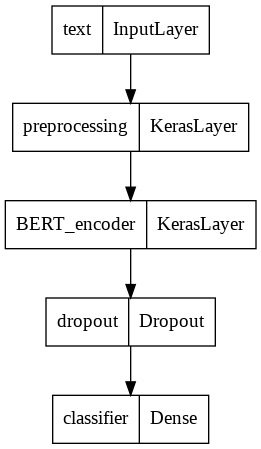

In [ ]:
#model structure
tf.keras.utils.plot_model(classifier_model)

In [ ]:
#binary classification problem, model outputs a probability
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
!pip install -U tf-models-official

     |████████████████████████████████| 2.2 MB 5.2 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 237 kB 52.4 MB/s 
     |████████████████████████████████| 1.2 MB 51.4 MB/s 
     |████████████████████████████████| 1.1 MB 38.5 MB/s 
     |████████████████████████████████| 636 kB 68.4 MB/s 
     |████████████████████████████████| 99 kB 9.1 MB/s 
     |████████████████████████████████| 352 kB 47.7 MB/s 
     |████████████████████████████████| 90 kB 9.4 MB/s 
     |████████████████████████████████| 47.8 MB 1.3 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=bfd851ba1c33e8b71d365bca2c672e7927d08097cc16deaf81b0db44ef0d6fb9
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=cb837846582f9c77ee8a34fba2b5283c581904a9d000c93819c78577edcc4ad4
  Stored i

In [ ]:
X_train.shape

(939,)

In [ ]:
#X_train = tf.convert_to_tensor(X_train)

from official.nlp import optimization  # to create AdamW optimizer


epochs = 5
steps_per_epoch = 939
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [ ]:
history = classifier_model.fit(X_train, y_train, epochs=5)

Epoch 1/5
30/30 [==============================] - 253s 8s/step - loss: 0.9246 - binary_accuracy: 0.4856
Epoch 2/5
30/30 [==============================] - 234s 8s/step - loss: 0.5681 - binary_accuracy: 0.7891
Epoch 3/5
30/30 [==============================] - 238s 8s/step - loss: 0.4346 - binary_accuracy: 0.8062
Epoch 4/5
30/30 [==============================] - 239s 8s/step - loss: 0.3162 - binary_accuracy: 0.8456
Epoch 5/5
30/30 [==============================] - 239s 8s/step - loss: 0.1400 - binary_accuracy: 0.9446


In [ ]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

8/8 [==============================] - 23s 2s/step - loss: 0.0264 - binary_accuracy: 0.9957
Loss: 0.026439210399985313
Accuracy: 0.9957447052001953


In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' 
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [ ]:
examples = [
    'defund the police they are killers and are racist',
    'i support the police blue lives matter they make us safe',
    'fuck the police'
]

In [ ]:
#acab: 0
#blm: 1

results = tf.sigmoid(classifier_model(tf.constant(examples)))
print_my_examples(examples, results)

input: defund the police they are killers and are racist : score: 0.025879
input: i support the police blue lives matter they make us safe : score: 0.922179
input: fuck the police                : score: 0.013126



In [ ]:
classifier_model.save("bert_police_classifier_final", include_optimizer=False)

INFO:tensorflow:Assets written to: bert_police_classifier_final/assets


INFO:tensorflow:Assets written to: bert_police_classifier_final/assets


In [ ]:
reloaded_model = tf.saved_model.load("/content/drive/MyDrive/bert_police_classifier_final")

In [ ]:
results = tf.sigmoid(reloaded_model(tf.constant(examples)))
print_my_examples(examples, results)

input: defund the police they are killers and are racist : score: 0.025879
input: i support the police blue lives matter they make us safe : score: 0.922179
input: fuck the police                : score: 0.013126

